In [1]:
import numpy as np
import sys
import torch

In [2]:
import matplotlib.pyplot as plt

In [3]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
sys.path.append('E:\code\scone\scone-main')

In [5]:
from scone.CIFAR.models.wrn import WideResNet

In [33]:
class WideResNet_SSND(nn.Module):
    def __init__(self, wrn):
        super().__init__()
        self.wrn = wrn
        self.num_classes = self.wrn.fc.out_features
        self.classifier = self.wrn.fc
        self.wrn.fc = nn.Identity()
        self.ood_fc1 = nn.Linear(self.classifier.in_features, 300)
        self.ood_fc2 = nn.Linear(300, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.wrn(x)
        x_class = self.classifier(x)

        x_ood = self.ood_fc1(x)
        x_ood = self.relu(x_ood)
        x_ood = self.ood_fc2(x_ood)

        x_all = torch.cat([x_class, x_ood], dim=1)

        return x_all

In [6]:
if torch.cuda.is_available:
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cuda


In [96]:
m = WideResNet(40,10,widen_factor=2)
m.load_state_dict(torch.load('E:\code\scone\scone-main\scone\CIFAR\snapshots\save\cifar10\svhn\scone\steps\scone_0.0_1_0.05_1_1_1.5_0.5_0.1_epoch_90.pt'))
m.to(device=device)

WideResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (block1): NetworkBlock(
    (layer): Sequential(
      (0): BasicBlock(
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (convShortcut): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BasicBlock(
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(32, 

In [8]:
batch_size = 512

In [9]:
from torchvision.datasets import CIFAR10,SVHN

cifar10 = CIFAR10(root='data/cifar-10',download=True)
svhn = SVHN(root='data/svhn',download=True)
corCIFAR10 = np.load('E:\code\scone\data\CorCIFAR10\CorCIFAR10_train\gaussian_noise.npy')

Files already downloaded and verified
Using downloaded and verified file: data/svhn\train_32x32.mat


In [33]:
in_set = []
in_label = []
for i in range(batch_size):
    in_set.append(np.transpose(cifar10[i][0],(2,1,0)))
    in_label.append(cifar10[i][1])
in_set = torch.tensor(in_set).to(device=device,dtype=torch.float)

In [11]:
out_set = []
for i in range(batch_size):
    out_set.append(np.transpose(svhn[i][0],(2,1,0)))
out_set = torch.tensor(out_set).to(device=device,dtype=torch.float)

In [12]:
cor_set = []
for i in range(batch_size):
    cor_set.append(np.transpose(corCIFAR10[i],(2,1,0)))
cor_set = torch.tensor(cor_set).to(device = device,dtype = torch.float)

In [31]:
cor_label = np.load('E:\code\scone\data\CorCIFAR10\CorCIFAR10_train\labels.npy')[:512]

In [97]:
in_output = m(in_set)
out_output = m(out_set)
cor_output = m(cor_set)

In [98]:
in_output = in_output.detach().cpu()
out_output = out_output.detach().cpu()
cor_output = cor_output.detach().cpu()

In [99]:
Ein = -torch.logsumexp(in_output,dim=1)
Eout = -torch.logsumexp(out_output,dim=1)
Ecor = -torch.logsumexp(cor_output,dim=1)

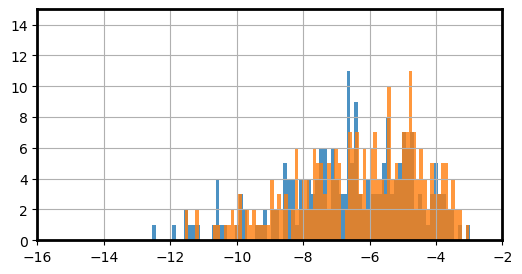

In [121]:
fig, ax = plt.subplots(1,1, figsize=(6,3))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
#ax.hist(Eout[:52],bins=80,label='OOD',alpha=0.8,)
ax.hist(Ein[:205],bins=80,label='ID',alpha=0.8)
ax.hist(Ecor[:256],bins=80,label='COR',alpha=0.8)

#ax.legend()
ax.set_xlim(-16,-2)
ax.set_ylim(0,15)
ax.grid(True)
#plt.savefig(r'E:\code\scone\figures\scone\Edist_epoch90.png',transparent=True,dpi=1200)

In [37]:
Yin = np.argmax(in_output,axis = 1)
Ycor = np.argmax(cor_output,axis = 1)

In [39]:
incor = Yin - np.array(in_label)
corcor = Ycor - np.array(cor_label)

In [41]:
np.count_nonzero(corcor)

345

In [94]:
m.get_parameter('fc.weight')

Parameter containing:
tensor([[-1.1175e-01, -1.0971e-04,  4.3582e-05,  ...,  5.4255e-04,
         -3.4888e-03,  1.8925e-01],
        [-1.6320e-01, -8.7144e-04,  1.2568e-04,  ...,  1.5180e-03,
         -2.5533e-03, -1.0379e-02],
        [-6.2777e-02,  8.5294e-04,  6.4894e-05,  ...,  1.3508e-03,
         -1.1831e-03,  3.8769e-02],
        ...,
        [ 1.9177e-03,  3.4592e-04, -1.3170e-04,  ...,  7.5517e-04,
         -1.1580e-03, -7.8903e-02],
        [-1.3940e-03, -3.3767e-04, -5.3425e-05,  ..., -5.8352e-04,
          3.7715e-03, -4.0688e-02],
        [ 3.4645e-01,  9.2316e-05, -1.0730e-05,  ..., -2.0238e-03,
          2.0538e-03, -6.7478e-02]], device='cuda:0', requires_grad=True)

In [90]:
mm.get_parameter('classifier')

AttributeError: `classifier` is not an nn.Parameter

In [93]:
p = mm._parameters.items()

In [44]:
list(mm.parameters())[-6].shape

torch.Size([10, 128])

In [66]:
mm.parameters()

<generator object Module.parameters at 0x0000024CA4F20CF0>

In [71]:
from torchvision.datasets import CIFAR10,SVHN

In [8]:
cifar10 = CIFAR10(root='../scone/data/',download=True)
svhn = SVHN(root='../scone/data/',download=True)

Files already downloaded and verified


  0%|          | 0/182040794 [00:00<?, ?it/s]

In [10]:
import numpy as np
import torch
import torch.utils.data as data
import torchvision

from torchvision import datasets
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, ConcatDataset


import os.path as osp
from torch.utils.data import Dataset
from tqdm import tqdm

import os

from random import sample, random

In [11]:
class CorCIFARDataset(data.Dataset):
    def __init__(self,d, cortype='gaussian_noise'):

        mean = [x / 255 for x in [125.3, 123.0, 113.9]]
        std = [x / 255 for x in [63.0, 62.1, 66.7]]

        self._image_transformer = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

        images = np.array(d)[:,0]
        labels = np.array(d)[:,1]

        self.data = images
        self.label = labels

        self.num_class = 10

    def __getitem__(self, index):
        img, label = self.data[index], self.label[index]
        
        img = self._image_transformer(img)
        
        return [img, label]

    def __len__(self):
        return len(self.data)


In [11]:
corcifar10 = CorCIFARDataset(cifar10)

C:\Users\Sage\AppData\Local\Temp\ipykernel_15264\1013146540.py:12: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  images = np.array(d)[:,0]
C:\Users\Sage\AppData\Local\Temp\ipykernel_15264\1013146540.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  images = np.array(d)[:,0]
C:\Users\Sage\AppData\Local\Temp\ipykernel_15264\1013146540.py:13: FutureWarning: The input 

In [13]:
def gaussian_noise(x, severity=1):
    c = [0.04, 0.06, .08, .09, .10][severity - 1]

    x = np.array(x) / 255.
    return np.clip(x + np.random.normal(size=x.shape, scale=c), 0, 1) * 255

In [28]:
gauss = []
for image, label in corcifar10:
    corimage = gaussian_noise(image)
    gauss.append([corimage,label])

In [29]:
np.shape(gauss)

d:\Anaconda\envs\pytorch\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


(50000, 2)

In [30]:
np.save('./data/gaussian_noise.npy',gauss)

d:\Anaconda\envs\pytorch\lib\site-packages\numpy\lib\npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [44]:
n = WideResNet_SSND(m)
n.load_state_dict(torch.load('E:\code\scone\scone-main\scone\CIFAR\snapshots\save\cifar10\svhn\woods_nn\ed2_99epwoods_nn_1_1_1_0.05_1_1.5_0.5_0.1_epoch_99.pt'))

<All keys matched successfully>

In [45]:
torch.norm(list(n.parameters())[-2])

tensor(2.0816, grad_fn=<NormBackward1>)

In [33]:
def from_ssnd(wrn_ssnd):
    wrn = wrn_ssnd.wrn
    wrn.fc = nn.Linear(128,10)
    return wrn
    

In [34]:
wrn = from_ssnd(n)

In [35]:
print(wrn)

WideResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (block1): NetworkBlock(
    (layer): Sequential(
      (0): BasicBlock(
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (convShortcut): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BasicBlock(
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(32, 

In [62]:
9%10

9

In [1]:
import pickle

In [7]:
ed = pickle.load(open(r'E:\code\scone\scone-main\scone\CIFAR\results\cifar10\svhn\scone\scone_-10.0_1_0.05_1_1_1.5_0.5_0.1.pkl','rb'))

In [49]:
normal = pickle.load(open(r'E:\code\scone\scone-main\scone\CIFAR\results\cifar10\svhn\scone\scone_-10.0_1_0.05_1_1_1.5_0.5_0.1.pkl','rb'))

In [9]:
find = pickle.load(open(r'E:\code\scone\scone-main\scone\CIFAR\results\cifar10\svhn\scone\scone_0.0_1_0.05_1_1_1.5_0.5_0.1.pkl','rb'))

In [51]:
find2 = pickle.load(open(r'E:\code\scone\scone-main\scone\CIFAR\results\cifar10\svhn\woods_nn\freeze_classifier_woods_nn_1_1_1_0.05_1_1.5_0.5_0.1.pkl','rb'))

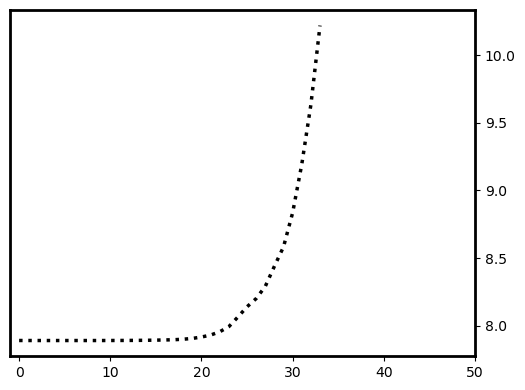

In [55]:
fig, ax = plt.subplots(1,1, figsize=(6,4.5))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
#ax.plot(ed['fpr95_test'],label='fpr95',linewidth=2.5)
#ax.plot(ed['auroc_test'],label='auroc',linewidth=2.5)
#ax.plot(ed['fpr95_test'],linewidth=2.5,label='fpr95')
#ax.plot(ed['auroc_test'],linewidth=2.5,label='auroc')
#ax.plot(ed['test_accuracy'],label='test cls accuracy',linewidth=2.5,linestyle='--')
#ax.plot(ed['test_accuracy_cor'],label='cor test cls acu',linewidth=2.5,linestyle='--')
ax.plot(find2['etas'],linewidth=2.5,linestyle=':',color='black')
#ax.plot(ed['etas'][1],label='norm of classifier weight',linewidth=2.5,linestyle=':',color='black')
#ax.plot(normal['etas'],label='norm of classifier weight',linewidth=2.5,linestyle=':',color='blue')
#ax.legend()
ax.set_xlim(-1,50)
#ax.set_ylim(-1,5)
ax.tick_params(right= True,left=False,labelright=True,labelleft=False)
#ax.grid(True)
plt.savefig(r'E:\code\scone\figures\woods_nn\freeze_50ep_woods_nn_cls_weights.png',transparent=True,dpi=1200)

In [26]:
stop = -9.329691373903692
eta = [stop]
for i in range(len(find['etas'])):
    eta.insert(0,eta[0]+find['etas'][-(i+1)])

In [36]:
set = np.ones(100)*(-10)

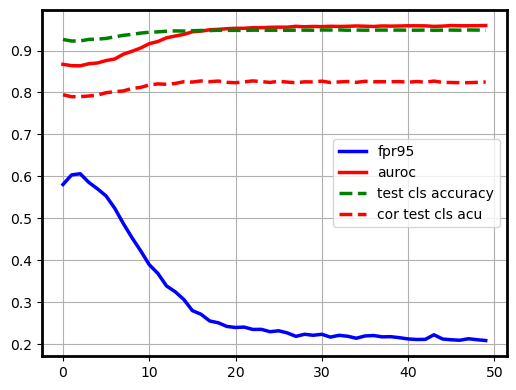

In [50]:
fig, ax = plt.subplots(1,1, figsize=(6,4.5))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.plot(normal['fpr95_test'],label='fpr95',linewidth=2.5,color='blue')
ax.plot(normal['auroc_test'],label='auroc',linewidth=2.5,color='red')
#ax.plot(ed['fpr95_test'],linewidth=2.5,label='fpr95')
#ax.plot(ed['auroc_test'],linewidth=2.5,label='auroc')
ax.plot(normal['test_accuracy'],label='test cls accuracy',linewidth=2.5,linestyle='--',color='green')
ax.plot(normal['test_accuracy_cor'],label='cor test cls acu',linewidth=2.5,linestyle='--',color='red')
ax.legend()
#ax.set_xlim(-1,10)
#ax.set_ylim(-.02,1.03)
ax.grid(True)
#plt.savefig('freeze_ed2_woods_nn_auc.png',transparent=True,dpi=1200)

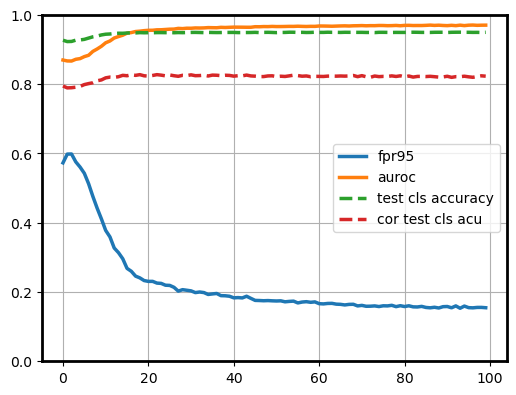

In [48]:
fig, ax = plt.subplots(1,1, figsize=(6,4.5))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.plot(find['fpr95_test'],label='fpr95',linewidth=2.5)
ax.plot(find['auroc_test'],label='auroc',linewidth=2.5)
#ax.plot(ed['fpr95_test'],linewidth=2.5,label='fpr95')
#ax.plot(ed['auroc_test'],linewidth=2.5,label='auroc')
ax.plot(find['test_accuracy'],label='test cls accuracy',linewidth=2.5,linestyle='--')
ax.plot(find['test_accuracy_cor'],label='cor test cls acu',linewidth=2.5,linestyle='--')
ax.legend()
#ax.set_xlim(-1,10)
ax.set_ylim(0,1)
ax.grid(True)
plt.savefig(r'E:\code\scone\figures\scone\find_scone.png',transparent=True,dpi=1200)

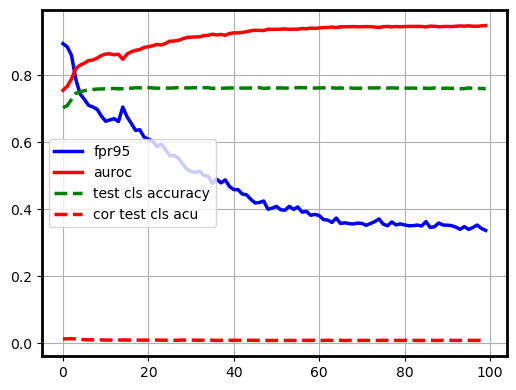

In [23]:
fig, ax = plt.subplots(1,1, figsize=(6,4.5))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.plot(find2['fpr95_test'],label='fpr95',linewidth=2.5,color='blue')
ax.plot(find2['auroc_test'],label='auroc',linewidth=2.5,color='red')
#ax.plot(ed['fpr95_test'],linewidth=2.5,label='fpr95')
#ax.plot(ed['auroc_test'],linewidth=2.5,label='auroc')
ax.plot(find2['test_accuracy'],label='test cls accuracy',linewidth=2.5,linestyle='--',color='green')
ax.plot(find2['test_accuracy_cor'],label='cor test cls acu',linewidth=2.5,linestyle='--',color='red')
ax.legend()
#ax.set_xlim(-1,10)
#ax.set_ylim(-.02,1.03)
ax.grid(True)
#plt.savefig('freeze_ed2_woods_nn_auc.png',transparent=True,dpi=1200)

In [51]:
ed

{'dataset': 'cifar10',
 'model': 'wrn',
 'epochs': 50,
 'learning_rate': 0.0001,
 'batch_size': 512,
 'oe_batch_size': 256,
 'test_bs': 200,
 'momentum': 0.9,
 'decay': 0.0005,
 'layers': 40,
 'widen_factor': 2,
 'droprate': 0.3,
 'results_dir': 'results',
 'checkpoints_dir': '',
 'load_pretrained': 'snapshots/pretrained',
 'test': False,
 'ngpu': 1,
 'gpu_id': 1,
 'prefetch': 0,
 'score': 'woods_nn',
 'seed': 1,
 'classification': True,
 'aux_out_dataset': 'svhn',
 'test_out_dataset': 'svhn',
 'pi_1': 0.5,
 'pi_2': 0.1,
 'pseudo': 0.01,
 'start_epoch': 50,
 'cortype': 'gaussian_noise',
 'in_constraint_weight': 1,
 'out_constraint_weight': 1,
 'ce_constraint_weight': 1,
 'false_alarm_cutoff': 0.05,
 'lr_lam': 1,
 'ce_tol': 2,
 'penalty_mult': 1.5,
 'constraint_tol': 0,
 'eta': 0.0,
 'alpha': 0.5,
 'm_in': -25.0,
 'm_out': -5.0,
 'T': 1.0,
 'energy_vos_lambda': 2,
 'oe_lambda': 0.5,
 'wandb_name': '',
 'etas': [0.5690241127178587,
  0.5711322385689308,
  0.5902172758661467,
  0.62351538

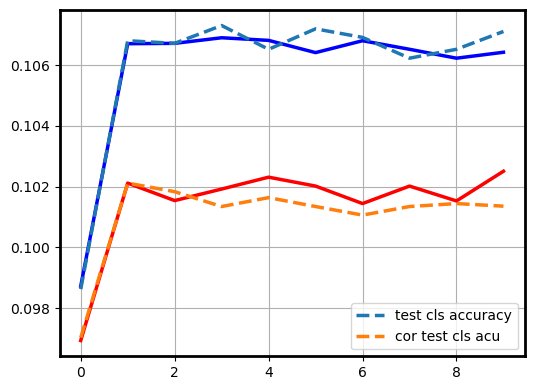

In [61]:
fig, ax = plt.subplots(1,1, figsize=(6,4.5))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
#ax.plot(pretrain['test_accuracy'],label='test accuracy',linewidth=2.5,color='blue')
#ax.plot(pretrain['test_accuracy_cor'],label='cor test cls acu',linewidth=2.5,color='red')
ax.plot(ed['test_accuracy'],linewidth=2.5,color='blue')
ax.plot(ed['test_accuracy_cor'],linewidth=2.5,color='red')
ax.plot(sco['test_accuracy'],label='test cls accuracy',linewidth=2.5,linestyle='--')
ax.plot(sco['test_accuracy_cor'],label='cor test cls acu',linewidth=2.5,linestyle='--')
ax.legend()
#ax.set_xlim(-1,10)
ax.grid(True)
#plt.savefig('pretrain&ed2-dashed_acu.png',transparent=True,dpi=1200)

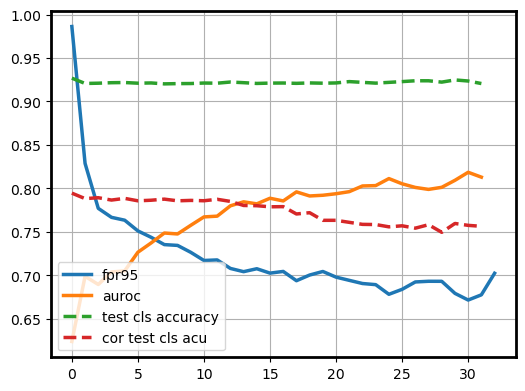

In [7]:
fig, ax = plt.subplots(1,1, figsize=(6,4.5))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.plot(fpr95,label='fpr95',linewidth=2.5,)
ax.plot(auroc,label='auroc',linewidth=2.5)
#ax.plot(ed['fpr95_test'],linewidth=2.5,label='fpr95')
#ax.plot(ed['auroc_test'],linewidth=2.5,label='auroc')
ax.plot(test,label='test cls accuracy',linewidth=2.5,linestyle='--')
ax.plot(cor,label='cor test cls acu',linewidth=2.5,linestyle='--')
ax.legend()
#ax.set_xlim(-1,10)
#ax.set_ylim(-.02,1.03)
ax.grid(True)
plt.savefig('ed3_woods_nn.png',transparent=True,dpi=1200)

In [29]:
gauss = np.load('E:\code\scone\data\CorCIFAR100\CIFAR-100-C\labels.npy')

In [30]:
len(gauss)

50000

In [34]:
test = gauss[:10000]

In [35]:
len(test)

10000

In [33]:
np.save('E:\code\scone\data\CorCIFAR100\CIFAR100_test\labels.npy',test)

In [49]:
x = torch.tensor([[1,2],[1,2]])
print(x)
y = torch.logsumexp(x,dim=1)
print(torch.exp(y))

tensor([[1, 2],
        [1, 2]])
tensor([10.1073, 10.1073])


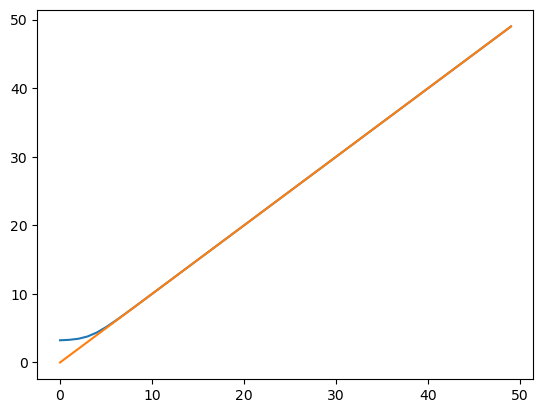

In [126]:
Y = []
for i in range(50):
    x = torch.tensor(np.ones(10))
    x[i//50] = i%50
    y = torch.logsumexp(x,dim=0)
    Y.append(y)
plt.plot(Y)
plt.plot(range(50))